# Data Ingestion, Preprocessing \+ EDA

### Imports

In [ ]:
# !pip install geopandas
# !pip install osmnx


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import importlib
import geopandas as gpd
import osmnx as ox
import ast
from collections import Counter
from sklearn.neighbors import NearestNeighbors

## Data Sources
### Inside Airbnb Dataset

Inside Airbnb Data Dictionary can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596)

As well as information onthe data assumptions can be found [here](https://insideairbnb.com/data-assumptions/)

### Crime Data
Crime data for four cities and Airbnb listing data were ingested and converted into GeoDataFrames using latitude and longitude coordinates.

A spatial join with U.S. Census Tract boundaries was performed to assign a GEOID to each crime incident and Airbnb listing. 

Crime data were aggregated by census tract to compute total crime counts per GEOID. These tract-level crime counts were then merged with the Airbnb listings dataset using the GEOID identifier, producing a final dataset that links each listing tract-level crime information.

**Note**: Crime data - incidents from 2023, Airbnb - September 2025 snapshot

In [3]:
# Add src to sys.path
# # Go up one directory from the current notebook's location and append the 'src' folder
module_path = os.path.abspath(os.path.join('..', 'src')) 
# module_path = os.path.abspath('src')
# if module_path not in sys.path:
#     sys.path.insert(0, module_path)

# sys.path.append(os.path.join(os.getcwd(), 'src'))


In [4]:
import sys
import os
import importlib

# Force the project path to the absolute top of the list
project_path = '/datasets/_deepnote_work'
if project_path in sys.path:
    sys.path.remove(project_path)
sys.path.insert(0, project_path)

# Clear any cached failed imports
importlib.invalidate_caches()

# Try the import again
from src.data_loader import crime_data_load, population_data_load, walkability_data_load, airbnb_data_load, assign_census_tract_id, agg_by_census_tract
from src import config
from src.data_loader import haversine_km, anchors, add_location_distance_features, impute_by_nearest_neighbor_efficient
print(config.PROJECT_ROOT)



/datasets/_deepnote_work


In [5]:
# load census tracts once
census_gdf = gpd.read_file(config.PATHS["census"])

census_gdf = census_gdf.to_crs(config.CRS)

# initialize results
dfs_list = []

# get airbnb and crime data for each city and join them on geoid
for city in config.CITIES:
    # Get column mapping for this city
    crime_cols = config.COL_MAP["crime"][city]

    # print(city)
    
    # load crime and airbnb data using the mapped columns
    crime_gdf = crime_data_load(
        config.PATHS["crime"][city],
        lat_col=crime_cols["lat"],
        long_col=crime_cols["long"],
        wkt_col=crime_cols.get("wkt")
    )

    # filter only 2023 for San diego(SD) city as the raw file contains data for all years
    if city =="SD":
        crime_gdf = crime_gdf.loc[crime_gdf["year"]==2023, :]
    
    # load airbnb data
    airbnb_gdf = airbnb_data_load(
        config.PATHS["airbnb"][city],
        lat_col="latitude",
        long_col="longitude"
    )

    # add a city column to airbnb data for reference
    airbnb_gdf["source_city"] = city
    
    # assign census tract IDs to crime and airbnb
    crime_gdf = assign_census_tract_id(crime_gdf, census_gdf)
    airbnb_gdf = assign_census_tract_id(airbnb_gdf, census_gdf)
    
    # aggregate by census tract for crime data and get count of total crimes
    crime_by_geoid_df = agg_by_census_tract(crime_gdf)

    # Join crime with airbnb data to get count of crimes for each listing
    airbnb_crime_gdf = pd.merge(
                    airbnb_gdf,
                    crime_by_geoid_df,
                    on="GEOID",
                    how="left"
                )
    dfs_list.append(airbnb_crime_gdf)
    
# final df
airbnb_crime_df = pd.concat(dfs_list, ignore_index=True)


/datasets/_deepnote_work/src/data_loader.py:98: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [6]:
airbnb_crime_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69078 entries, 0 to 69077
Data columns (total 86 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            69078 non-null  int64   
 1   listing_url                                   69078 non-null  object  
 2   scrape_id                                     69078 non-null  int64   
 3   last_scraped                                  69078 non-null  object  
 4   source                                        69078 non-null  object  
 5   name                                          69077 non-null  object  
 6   description                                   67818 non-null  object  
 7   neighborhood_overview                         33591 non-null  object  
 8   picture_url                                   69078 non-null  object  
 9   host_id                                   

### Population data
Population data at the GEOID / census tract level is downloaded from the https://data.census.gov and the table is ACSDT5Y2023.B01003

This is merged with the previous dataframe to get population at GEOID level

In [7]:

# get the population data
population_df = population_data_load(config.PATHS["population"])

# merge the airbnb with crime data and population on GEOID
airbnb_crime_population_df = airbnb_crime_df.merge(population_df,
                                                    how='left',
                                                    on="GEOID")
# airbnb_crime_population_df is the airbnb listing data enriched with crime, population at teh GEOID level
airbnb_crime_population_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69078 entries, 0 to 69077
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            69078 non-null  int64   
 1   listing_url                                   69078 non-null  object  
 2   scrape_id                                     69078 non-null  int64   
 3   last_scraped                                  69078 non-null  object  
 4   source                                        69078 non-null  object  
 5   name                                          69077 non-null  object  
 6   description                                   67818 non-null  object  
 7   neighborhood_overview                         33591 non-null  object  
 8   picture_url                                   69078 non-null  object  
 9   host_id                                   

### Walkabitily Data Dictionary 
link: https://geodata.epa.gov/arcgis/rest/services/OA/WalkabilityIndex/MapServer/0
I could not find the dictionary for the meta data set but here is a dicitonary for what I beleive is a subset of the meta dataset.
Here are the columns that I believe are the most relavant to our project :

    D5BR ( type: esriFieldTypeDouble, alias: Jobs within 45-minute transit commute, distance decay (walk network travel time, GTFS schedules) weighted )
    D5BE ( type: esriFieldTypeDouble, alias: Working age population within 45-minute transit commute, time decay (walk network travel time, GTFS schedules) weighted )
    D5CR ( type: esriFieldTypeDouble, alias: Proportional Accessibility to Regional Destinations - Auto: Employment accessibility expressed as a ratio of total CBSA accessibility )
    D5CRI ( type: esriFieldTypeDouble, alias: Regional Centrality Index – Auto: CBG [D5cr] score relative to max CBSA [D5cr] score )
    D5CE ( type: esriFieldTypeDouble, alias: Proportional Accessibility to Regional Destinations - Auto: Working age population accessibility expressed as a ratio of total CBSA accessibility )
    D5CEI ( type: esriFieldTypeDouble, alias: Regional Centrality Index – Auto: CBG [D5ce] score relative to max CBSA [D5ce] score )
    D5DR ( type: esriFieldTypeDouble, alias: Proportional Accessibility of Regional Destinations - Transit: Employment accessibility expressed as a ratio of total MSA accessibility )
    D5DRI ( type: esriFieldTypeDouble, alias: Regional Centrality Index – Transit: CBG [D5dr] score relative to max CBSA [D5dr] score )
    D5DE ( type: esriFieldTypeDouble, alias: Proportional Accessibility of Regional Destinations - Transit: Working age population accessibility expressed as a ratio of total MSA accessibility )
    D5DEI ( type: esriFieldTypeDouble, alias: Regional Centrality Index – Transit: CBG [D5de] score relative to max CBSA [D5de] score )
    D2A_Ranked ( type: esriFieldTypeDouble, alias: Quantile ranked order (1-20) of [D2a_EpHHm] from lowest to highest )
    D2B_Ranked ( type: esriFieldTypeDouble, alias: Quantile ranked order (1-20) of [D2b_E8MixA] from lowest to highest )
    D3B_Ranked ( type: esriFieldTypeDouble, alias: Quantile ranked order (1-20) of [D3b] from lowest to highest )
    D4A_Ranked ( type: esriFieldTypeDouble, alias: Quantile ranked order (1,13-20) of [D4a] from lowest to highest )
    NatWalkInd ( type: esriFieldTypeDouble, alias: Walkability Index )

####   National Walkability Index Definition
The ranked scores were then weighted by the following formula:16
Final National Walkability Index score = (w/3) + (x/3) + (y/6) + (z/6)
Where w =  block group’s ranked score for intersection density 
x = block group’s ranked score for proximity to transit stops 
y = block group’s ranked score for employment mix 
z = block group’s ranked score for employment and household mix
The block groups are assigned their final National Walkability Index scores on a scale of 1 to 20 
(Figure 3).

Given the formula, transit is already accounted for to some extent so we may not need to find other transit metrics
1 - 5.75            Least walkable
5.76 - 10.5         Below average walkable
10.51 - 15.25       Above average walkable
15.26 - 20          Most walkable
https://www.epa.gov/sites/default/files/2021-06/documents/national_walkability_index_methodology_and_user_guide_june2021.pdf

In [8]:
# load walkabilty data
walkability_scores_df = walkability_data_load(config.PATHS["walkability"])

walkability_scores_df = walkability_scores_df.groupby('GEOID')['NatWalkInd'].mean().reset_index()

# merge the airbnb with crime, population with new walkability data on GEOID
final_raw_df = airbnb_crime_population_df.merge(walkability_scores_df,how='left',on="GEOID")

walkability_scores_df.describe()

,NatWalkInd
count,74133.000000
mean,9.498403
std,4.080539
min,1.000000
25%,6.083333
50%,9.000000
75%,13.125000
max,19.833333


In [9]:
for i in walkability_scores_df.columns:
    print(walkability_scores_df[i].describe())

count           74133
unique          74133
top       01001020100
freq                1
Name: GEOID, dtype: object
count    74133.000000
mean         9.498403
std          4.080539
min          1.000000
25%          6.083333
50%          9.000000
75%         13.125000
max         19.833333
Name: NatWalkInd, dtype: float64


*final_raw_df* is the airbnb listing data enriched with crime, population and walkability scores at the GEOID level


In [10]:
# this the final raw dataset from different data sources spatially joined on GEOID before feature engineering 
output_path = config.PROJECT_ROOT + "/data/preprocessed/final_raw_dataset.csv"
# final_raw_df.to_csv(output_path, index=False)

In [11]:
final_raw_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69078 entries, 0 to 69077
Data columns (total 88 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            69078 non-null  int64   
 1   listing_url                                   69078 non-null  object  
 2   scrape_id                                     69078 non-null  int64   
 3   last_scraped                                  69078 non-null  object  
 4   source                                        69078 non-null  object  
 5   name                                          69077 non-null  object  
 6   description                                   67818 non-null  object  
 7   neighborhood_overview                         33591 non-null  object  
 8   picture_url                                   69078 non-null  object  
 9   host_id                                   

In [12]:
non_nan_rows_df = final_raw_df[final_raw_df[["id", "GEOID", "crime_count", "population", "NatWalkInd"]].notna().all(axis=1)]
len(non_nan_rows_df)

47876

In [13]:
wal_nan_rows_df = final_raw_df[final_raw_df[["NatWalkInd"]].isna().any(axis=1)]
wal_nan_rows_df["GEOID"].unique()

array(['06001403401', '06001402801', '06001403302', '06001403301',
       '06001402802', '06001403402', '06075016601', '06075020601',
       '06075033002', '06075061401', '06075061507', '06075020802',
       '06075020801', '06075045202', '06075061101', '06075015401',
       '06075020202', '06075035102', '06075016602', '06075010401',
       '06075020702', '06075061504', '06075045201', '06075020602',
       '06075020701', '06075025501', '06075010201', '06075010701',
       '06075012406', '06075017602', '06075010202', '06075061503',
       '06075060702', '06075020101', '06075015402', '06075010402',
       '06075017804', '06075016101', '06075010101', '06075020102',
       '06075010901', '06075015702', '06075011101', '06075013001',
       '06075013402', '06075016102', '06075061506', '06075015202',
       '06075047903', '06075012403', '06075012801', '06075010702',
       '06075015701', '06075035101', '06075012802', '06075013002',
       '06075061402', '06075010902', '06075017603', '060750479

## Data Preprocessing and Feature Engineering

In [14]:
# Identify rating and availability related columns
final_df = final_raw_df
rating_cols = [col for col in final_df.columns if 'review_scores' in col]
availability_cols = [col for col in final_df.columns if 'availability' in col]

eda_cols = rating_cols + availability_cols

print("\n--- Descriptive Statistics for Rating and Availability Fields ---")
print(final_df[eda_cols].describe())

print("\n--- Missing Values in Rating and Availability Fields ---")
missing_values = final_df[eda_cols].isnull().sum()
missing_percentage = (final_df[eda_cols].isnull().sum() / len(final_df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage (%)': missing_percentage})
print(missing_df[missing_df['Missing Count'] > 0])


--- Descriptive Statistics for Rating and Availability Fields ---
       review_scores_rating  review_scores_accuracy  \
count          52125.000000            52118.000000   
mean               4.787094                4.808157   
std                0.406821                0.396505   
min                0.000000                0.000000   
25%                4.750000                4.790000   
50%                4.900000                4.920000   
75%                5.000000                5.000000   
max                5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               52118.000000           52111.000000   
mean                    4.763674               4.866226   
std                     0.419064               0.346666   
min                     0.000000               0.000000   
25%                     4.710000               4.880000   
50%                     4.890000               4.960000   
75%                     

In [15]:
print("--- Data Types of All Columns ---")
print(final_df.dtypes.to_string())

--- Data Types of All Columns ---
id                                                 int64
listing_url                                       object
scrape_id                                          int64
last_scraped                                      object
source                                            object
name                                              object
description                                       object
neighborhood_overview                             object
picture_url                                       object
host_id                                            int64
host_url                                          object
host_name                                         object
host_since                                        object
host_location                                     object
host_about                                        object
host_response_time                                object
host_response_rate                                obje

In [16]:
final_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,reviews_per_month,geometry,source_city,index_right,GEOID,ALAND,area_sqmiles,crime_count,population,NatWalkInd
0,3083,https://www.airbnb.com/rooms/3083,20250925032724,2025-09-25,city scrape,Room #2 - West Oakland,"4 blocks from West Oakland BART, 1 stop to San...",The neighborhood is in a historic district wit...,https://a0.muscache.com/pictures/hosting/Hosti...,3518,...,0.57,POINT (-122.29266 37.81013),OAK,8941.0,06001402200,715808.0,0.276373,495.0,2385.0,16.666667
1,5739,https://www.airbnb.com/rooms/5739,20250925032724,2025-09-25,city scrape,Mod Studio,"The Mod Studio is a cozy, clean and convenient...","We love the proximity to great restaurants, Wh...",https://a0.muscache.com/pictures/116966/376a1f...,9276,...,1.69,POINT (-122.25805 37.81266),OAK,2966.0,06001403701,173946.0,0.067161,361.0,2875.0,14.250000
2,24916,https://www.airbnb.com/rooms/24916,20250925032724,2025-09-25,city scrape,Studio w/garden and Patio close to Rockridge,Studio with patio garden just out the door. <...,"great neighborhood, for walking , beautiful ga...",https://a0.muscache.com/pictures/hosting/Hosti...,98716,...,0.79,POINT (-122.25175 37.83169),OAK,3588.0,06001404101,569281.0,0.219799,551.0,3155.0,17.416667
3,29521,https://www.airbnb.com/rooms/29521,20250925032724,2025-09-25,city scrape,Elegant Rockridge Home,"Lovely, light-filled, upper level 2BD/1 BA Que...","Centrally located, walking distance to Whole F...",https://a0.muscache.com/pictures/09205cda-384c...,124220,...,0.29,POINT (-122.25581 37.83618),OAK,1319.0,06001400300,1110841.0,0.428896,1008.0,5727.0,15.791667
4,30026,https://www.airbnb.com/rooms/30026,20250925032724,2025-09-25,city scrape,Temescal sunny townhome w/views every room 3 d...,This is a 3 level penthouse in the heart of Te...,"Original Temescal, centrally located near free...",https://a0.muscache.com/pictures/miso/Hosting-...,98716,...,0.03,POINT (-122.26264 37.8345),OAK,2779.0,06001401100,873332.0,0.337193,2035.0,5627.0,16.541667


In [17]:
final_df['source_city'].value_counts()

source_city
LA     45886
SD     13162
SF      7780
OAK     2250
Name: count, dtype: int64

### Inside Airbnb Data Cleaning to be addressed for Supervised Learning Model
* host_is_superhost t / f to 1 0 
* instant bookable t / f to 1 0
* host_response_rate convert to float
* room_type needs to be encoded
* amenitites needs to be encoded
* property type needs to be encoded

**For our supervised learning model, we will be using the number of reviews as our target variable. This is because we are trying to predict the popularity of an Airbnb listing. Should we drop all listings with less than 3 reviews to he data more reliable?**

**Should we focus on just the review_scores_rating field for our prediction? If so, we must drop all other review_scores fields for our Supervised Learning Model?**

In [18]:
print("--- Columns for Potential Dropping or Transformation ---")

# Identify ID/URL/long text columns likely to be dropped
columns_to_consider_dropping = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_id', 
    'host_url', 'host_profile_id', 'host_profile_url', 'host_name', 'host_about', 
    'host_thumbnail_url', 'host_picture_url', 'neighborhood_overview', 'description', 
    'name', 'calendar_updated', 'calendar_last_scraped', 'license', 'first_review', 'last_review'
    'price', 'estimated_revenue', 'number_of_reviews_ltm', 'number_of_review_l30d', 
]
print(f"\nColumns likely to be dropped: {columns_to_consider_dropping}")

# Identify columns for binary encoding
binary_encode_cols = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable'
]
print(f"\nColumns for binary encoding (t/f -> 1/0): {binary_encode_cols}")

# Identify columns for other transformations (e.g., one-hot)
other_cols = ['amenities', 'host_verifications', 'property_type', 'room_type']
print(f"\nColumns requiring other transformations: {other_cols}")

# Identify columns for other transformation host_response_rate, host_acceptance_rate
to_float_columns = ['host_response_rate', 'host_acceptance_rate', 'price']
percent_cols = ['host_response_rate', 'host_acceptance_rate']

# look into host_response_time groupings

# Also consider columns with very high missing values for potential dropping, if not imputed
high_missing_cols = missing_df[missing_df['Missing Percentage (%)'] > 20].index.tolist()
print(f"\nColumns with >20% missing values (consider imputation or dropping): {high_missing_cols}")

--- Columns for Potential Dropping or Transformation ---

Columns likely to be dropped: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_id', 'host_url', 'host_profile_id', 'host_profile_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'neighborhood_overview', 'description', 'name', 'calendar_updated', 'calendar_last_scraped', 'license', 'first_review', 'last_reviewprice', 'estimated_revenue', 'number_of_reviews_ltm', 'number_of_review_l30d']

Columns for binary encoding (t/f -> 1/0): ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

Columns requiring other transformations: ['amenities', 'host_verifications', 'property_type', 'room_type']

Columns with >20% missing values (consider imputation or dropping): ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


##### Binary Encoding of True / False Columns

In [19]:
# Columns identified for binary encoding
binary_encode_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

# Apply binary encoding: 't' -> 1, 'f' -> 0, others -> NaN, then fill NaN with 0
for col in binary_encode_cols:
    final_df[col] = final_df[col].map({'t': 1, 'f': 0}).astype('float64').fillna(0)

print("Binary encoding applied to the following columns (NaN filled with 0):")
for col in binary_encode_cols:
    print(f"- {col}: Data type now {final_df[col].dtype}")
    print(f"  Value counts:\n{final_df[col].value_counts(dropna=False)}\n")

print("First 5 rows of final_df with updated binary encoded columns:")
display(final_df[binary_encode_cols].head())

Binary encoding applied to the following columns (NaN filled with 0):
- host_is_superhost: Data type now float64
  Value counts:
host_is_superhost
0.0    40440
1.0    28638
Name: count, dtype: int64

- host_has_profile_pic: Data type now float64
  Value counts:
host_has_profile_pic
1.0    67248
0.0     1830
Name: count, dtype: int64

- host_identity_verified: Data type now float64
  Value counts:
host_identity_verified
1.0    60133
0.0     8945
Name: count, dtype: int64

- instant_bookable: Data type now float64
  Value counts:
instant_bookable
0.0    49409
1.0    19669
Name: count, dtype: int64

First 5 rows of final_df with updated binary encoded columns:


,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable
0,1.0,1.0,1.0,1.0
1,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0


##### Host_Response Rate, Host_Acceptance_Rate and Price Converting Text to Float

In [20]:
# Convert percentage columns to float
percent_cols = ['host_response_rate', 'host_acceptance_rate']
final_df[percent_cols] = (
    final_df[percent_cols]
    .replace('%', '', regex=True)
    .apply(pd.to_numeric, errors='coerce')
)
final_df[percent_cols] = final_df[percent_cols] / 100

# Price column: remove $ and commas, then convert
final_df['price'] = (
    final_df['price']
    .replace(r'[\$,]', '', regex=True)
    .pipe(pd.to_numeric, errors='coerce'))

##### Response Time: Categorical Encoding

In [21]:
# Group + map response time of hosts
# Mapping (fast = low number)
response_time_mapping = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3
}

# Apply mapping
final_df['host_response_time_ord'] = final_df['host_response_time'].map(response_time_mapping)

###### Aggregated Amenitiy Scores

In [22]:
def parse_amenities(x):
    if pd.isna(x):
        return []
    x = str(x).strip()

    # If it's a string representation of a Python list: "['Wifi', 'Kitchen']"
    if x.startswith('['):
        try:
            parsed = ast.literal_eval(x)
            return [str(a).strip() for a in parsed if str(a).strip()]
        except Exception:
            return []

    # If it's a string like "{Wifi, Kitchen, Washer}"
    x = x.replace('{', '').replace('}', '').replace('"', '').replace("'", "")
    return [a.strip() for a in x.split(',') if a.strip()]

final_df['amenities_list'] = final_df['amenities'].apply(parse_amenities)

# 3) Explore most common amenities
all_amenities = Counter()
for amenities in final_df['amenities_list']:
    all_amenities.update(amenities)

top_amenities_df = pd.DataFrame(
    all_amenities.most_common(30),
    columns=['amenity', 'count']
)

top_amenities_df

,amenity,count
0,Smoke alarm,65750
1,Wifi,63475
2,Carbon monoxide alarm,60267
3,Kitchen,59481
4,Hot water,54139
5,Hangers,53492
6,Essentials,52584
7,Hair dryer,52083
8,Iron,48646
9,Dishes and silverware,48095


In [23]:
# amenity encoding
safety_amenities = [
    'Smoke alarm',
    'Carbon monoxide alarm',
    'Fire extinguisher',
    'First aid kit'
]

convenience_amenities = [
    'Air conditioning', 'Heating', 'Washer', 'Dishwasher',
    'Free parking on premises', 'Free street parking',
    'Self check-in', 'Dedicated workspace', 'Private entrance', 'TV'
]

final_df['safety_amenities_count'] = final_df['amenities_list'].apply(
    lambda x: sum(a in x for a in safety_amenities)
)

final_df['convenience_amenities_count'] = final_df['amenities_list'].apply(
    lambda x: sum(a in x for a in convenience_amenities)
)


##### Rooom Type: One Hot Encoding

In [24]:
final_df['room_type'].value_counts()

room_type
Entire home/apt    51035
Private room       16721
Hotel room           833
Shared room          489
Name: count, dtype: int64

In [25]:

room_dummies = pd.get_dummies(
    final_raw_df['room_type'],
    prefix='room_type',
    dummy_na=True,
    dtype=int   # ensures 0/1 integers
)

final_df = pd.concat([final_raw_df, room_dummies], axis=1)

##### Property Type

In [26]:
final_df['property_type'].value_counts()

property_type
Entire home                      19198
Entire rental unit               16722
Private room in home              8065
Entire condo                      4252
Entire guesthouse                 3688
                                 ...  
Lighthouse                           1
Shared room in villa                 1
Cycladic home                        1
Shared room in boutique hotel        1
Room in resort                       1
Name: count, Length: 100, dtype: int64

In [27]:
unique_keywords = [
    'treehouse', 'tiny home', 'yurt', 'camper', 'rv', 'boat',
    'castle', 'dome', 'tower', 'cave', 'shepherd', 
    'train', 'bus', 'island', 'houseboat'
]

# Lowercase for matching
prop_lower = final_df['property_type'].str.lower().fillna('')

# Create flag if any keyword appears
final_df['is_unique_stay'] = prop_lower.apply(
    lambda x: int(any(keyword in x for keyword in unique_keywords))
)

In [28]:
final_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,host_response_time_ord,amenities_list,safety_amenities_count,convenience_amenities_count,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan,is_unique_stay
0,3083,https://www.airbnb.com/rooms/3083,20250925032724,2025-09-25,city scrape,Room #2 - West Oakland,"4 blocks from West Oakland BART, 1 stop to San...",The neighborhood is in a historic district wit...,https://a0.muscache.com/pictures/hosting/Hosti...,3518,...,0.0,"[Self check-in, Coffee maker, Private backyard...",4,5,0,0,1,0,0,0
1,5739,https://www.airbnb.com/rooms/5739,20250925032724,2025-09-25,city scrape,Mod Studio,"The Mod Studio is a cozy, clean and convenient...","We love the proximity to great restaurants, Wh...",https://a0.muscache.com/pictures/116966/376a1f...,9276,...,0.0,"[Self check-in, Mini fridge, Coffee maker: dri...",4,5,1,0,0,0,0,0
2,24916,https://www.airbnb.com/rooms/24916,20250925032724,2025-09-25,city scrape,Studio w/garden and Patio close to Rockridge,Studio with patio garden just out the door. <...,"great neighborhood, for walking , beautiful ga...",https://a0.muscache.com/pictures/hosting/Hosti...,98716,...,1.0,"[Coffee maker, Long term stays allowed, Dryer,...",3,5,1,0,0,0,0,0
3,29521,https://www.airbnb.com/rooms/29521,20250925032724,2025-09-25,city scrape,Elegant Rockridge Home,"Lovely, light-filled, upper level 2BD/1 BA Que...","Centrally located, walking distance to Whole F...",https://a0.muscache.com/pictures/09205cda-384c...,124220,...,0.0,"[Self check-in, Coffee maker, Dryer, Dishes an...",2,7,1,0,0,0,0,0
4,30026,https://www.airbnb.com/rooms/30026,20250925032724,2025-09-25,city scrape,Temescal sunny townhome w/views every room 3 d...,This is a 3 level penthouse in the heart of Te...,"Original Temescal, centrally located near free...",https://a0.muscache.com/pictures/miso/Hosting-...,98716,...,1.0,"[Coffee maker, Long term stays allowed, Dryer,...",2,3,1,0,0,0,0,0


##### Feature Scaling / Normalization
Population per Sq Mile
Crime Count per 1000
Crime per Sq miles

In [29]:
# Population per Square Mile
final_df['population_per_sqmile'] = final_df['population'] / final_df['area_sqmiles']
final_df['crime_per_1000'] = 1000*(final_df['crime_count'] / final_df['population'])
final_df['crime_per_sqmile'] = final_df['crime_count'] / final_df['area_sqmiles']

Convert host_since to years

In [30]:

final_df["host_since"] = pd.to_datetime(final_df["host_since"], errors='coerce')
final_df["last_scraped"] = pd.to_datetime(final_df["last_scraped"], errors='coerce')
final_df["host_years"] = np.round(((final_df["last_scraped"] - final_df["host_since"]).dt.days / 365), 2)
final_df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan,is_unique_stay,population_per_sqmile,crime_per_1000,crime_per_sqmile,host_years
0,3083,https://www.airbnb.com/rooms/3083,20250925032724,2025-09-25,city scrape,Room #2 - West Oakland,"4 blocks from West Oakland BART, 1 stop to San...",The neighborhood is in a historic district wit...,https://a0.muscache.com/pictures/hosting/Hosti...,3518,...,0,0,1,0,0,0,8629.627187,207.547170,1791.054699,16.98
1,5739,https://www.airbnb.com/rooms/5739,20250925032724,2025-09-25,city scrape,Mod Studio,"The Mod Studio is a cozy, clean and convenient...","We love the proximity to great restaurants, Wh...",https://a0.muscache.com/pictures/116966/376a1f...,9276,...,1,0,0,0,0,0,42807.868225,125.565217,5375.179280,16.57
2,24916,https://www.airbnb.com/rooms/24916,20250925032724,2025-09-25,city scrape,Studio w/garden and Patio close to Rockridge,Studio with patio garden just out the door. <...,"great neighborhood, for walking , beautiful ga...",https://a0.muscache.com/pictures/hosting/Hosti...,98716,...,1,0,0,0,0,0,14353.997712,174.643423,2506.831296,15.52


##### Price / Occupancy

In [31]:
final_df['price_per_person'] = final_df['price'] / final_df['accommodates']

#### Location Features

In [32]:
final_df = add_location_distance_features(
    final_df,
    city_col="source_city",
    lat_col="latitude",
    lon_col="longitude"
)

final_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,is_unique_stay,population_per_sqmile,crime_per_1000,crime_per_sqmile,host_years,price_per_person,dist_km_downtown,dist_km_airport,log_dist_km_downtown,log_dist_km_airport
0,3083,https://www.airbnb.com/rooms/3083,20250925032724,2025-09-25,city scrape,Room #2 - West Oakland,"4 blocks from West Oakland BART, 1 stop to San...",The neighborhood is in a historic district wit...,https://a0.muscache.com/pictures/hosting/Hosti...,3518,...,0,8629.627187,207.547170,1791.054699,16.98,62.5,1.996492,11.714659,1.097442,2.542756
1,5739,https://www.airbnb.com/rooms/5739,20250925032724,2025-09-25,city scrape,Mod Studio,"The Mod Studio is a cozy, clean and convenient...","We love the proximity to great restaurants, Wh...",https://a0.muscache.com/pictures/116966/376a1f...,9276,...,0,42807.868225,125.565217,5375.179280,16.57,47.5,1.474930,10.663343,0.906212,2.456451
2,24916,https://www.airbnb.com/rooms/24916,20250925032724,2025-09-25,city scrape,Studio w/garden and Patio close to Rockridge,Studio with patio garden just out the door. <...,"great neighborhood, for walking , beautiful ga...",https://a0.muscache.com/pictures/hosting/Hosti...,98716,...,0,14353.997712,174.643423,2506.831296,15.52,46.0,3.483709,12.562274,1.500451,2.607292
3,29521,https://www.airbnb.com/rooms/29521,20250925032724,2025-09-25,city scrape,Elegant Rockridge Home,"Lovely, light-filled, upper level 2BD/1 BA Que...","Centrally located, walking distance to Whole F...",https://a0.muscache.com/pictures/09205cda-384c...,124220,...,0,13352.896439,176.008381,2350.221689,15.38,62.5,3.785794,13.129088,1.565652,2.648236
4,30026,https://www.airbnb.com/rooms/30026,20250925032724,2025-09-25,city scrape,Temescal sunny townhome w/views every room 3 d...,This is a 3 level penthouse in the heart of Te...,"Original Temescal, centrally located near free...",https://a0.muscache.com/pictures/miso/Hosting-...,98716,...,0,16687.748272,361.649191,6035.110669,15.52,83.5,3.433579,13.103068,1.489207,2.646392


In [33]:
source_city_dummies = pd.get_dummies(
    final_df['source_city'],
    prefix='source_city',
    dummy_na=True,  # creates a column for missing values
    dtype=int
)

final_df = pd.concat([final_df, source_city_dummies], axis=1)

#### Date Related Features

In [34]:
# select only rows where reviews are >=1
final_df = final_df[final_df['number_of_reviews'] >= 1]

# Calculate reviews per year
# convert to datetime
final_df['last_scraped'] = pd.to_datetime(final_df['last_scraped'])
final_df['first_review'] = pd.to_datetime(final_df['first_review'])

# calculate listing age in years
final_df['listing_age_years'] = (final_df['last_scraped'] - final_df['first_review']).dt.days / 365

# calculate reviews per year
# cliping at 6 months 
# final_df['reviews_per_year'] = final_df['number_of_reviews'] / final_df['listing_age_years'].clip(lower=0.5)
# # fill na
# final_df['reviews_per_year'] = final_df['reviews_per_year'].fillna(0)

#laplace smoothing: (Reviews + alpha) / (Age + beta)
# Using 1 as a standard smoothing constant
final_df['reviews_per_year'] = (final_df['number_of_reviews'] + 1) / (final_df['listing_age_years'] + 1)

# fillna
final_df['reviews_per_year'] = final_df['reviews_per_year'].fillna(0)

#### Handling Missing Data / Imputation

In [35]:
# fill price by median price of that room type in that neighbourhood
final_df['price'] = final_df['price'].fillna(
    final_df.groupby(['source_city', 'neighbourhood_cleansed', 'room_type'])['price'].transform('median')
)

# if still NaN, group by City and Room Type (ignores neighborhood)
final_df['price'] = final_df['price'].fillna(
    final_df.groupby(['source_city', 'room_type'])['price'].transform('median')
)

# recalculate price_per_person 
final_df['price_per_person'] = final_df['price'] / final_df['accommodates'].replace(0, 1)

# replace 0 with nan
final_df['population'] = final_df['population'].replace(0, np.nan)

# fill NaN with the median population of that specific neighborhood
final_df['population'] = final_df['population'].fillna(
    final_df.groupby(['source_city', 'neighbourhood_cleansed'])['population'].transform('median')
)

# if still NaN (rare neighborhoods), use the city median
final_df['population'] = final_df['population'].fillna(
    final_df.groupby(['source_city'])['population'].transform('median')
)

# calculate your crime rate
final_df['crime_per_1000'] = (final_df['crime_count'] / final_df['population']) * 1000

# fill NaN values in 'bathrooms', 'beds', and 'bedrooms' with 0
final_df['bathrooms'] = final_df['bathrooms'].fillna(0)
final_df['beds'] = final_df['beds'].fillna(0)
final_df['bedrooms'] = final_df['bedrooms'].fillna(0)

final_df['bathrooms_per_bedroom'] = final_df['bathrooms'] / final_df['bedrooms'].replace(0, 1)


# fill responsiveness with -1 if na 
final_df['host_response_time_ord'] = final_df['host_response_time_ord'].fillna(-1)
final_df['host_response_rate'] = final_df['host_response_rate'].fillna(-1)
final_df['host_acceptance_rate'] = final_df['host_acceptance_rate'].fillna(-1)
final_df['host_listings_count'] = final_df['host_listings_count'].fillna(-1)
final_df['host_years'] = final_df['host_years'].fillna(0)



cols_to_distance_impute = [
    'NatWalkInd',
    'crime_per_1000',
    'crime_per_sqmile'
]
# Distance-based imputation for cols_to_distance_impute
def impute_by_nearest_neighbor_efficient(df_in, target_col, lat_col='latitude', lon_col='longitude'):
    df_temp = df_in.copy()

    # Identify rows with and without missing values in the target column
    df_missing = df_temp[df_temp[target_col].isna()]
    df_present = df_temp[df_temp[target_col].notna()]
    
    if df_missing.empty or df_present.empty:
        return df_temp # No imputation needed or possible
    
    # Convert latitude and longitude to radians for haversine distance metric
    coords_present_rad = np.deg2rad(df_present[[lat_col, lon_col]].values)
    coords_missing_rad = np.deg2rad(df_missing[[lat_col, lon_col]].values)

    # Build NearestNeighbors model on points where target_col is present
    # Using 'ball_tree' for efficiency with haversine metric
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='haversine')
    nn.fit(coords_present_rad)

    # Find the nearest neighbor for each missing point
    # k-neighbors returns distances and indices
    distances, indices = nn.kneighbors(coords_missing_rad)

    # Impute the missing values
    # indices is 2D, e.g., [[0], [1], [2]] so we flatten it
    closest_neighbors_indices_in_present_df = indices.flatten()
    
    # Get the actual index from the original df_present to align values
    original_indices_of_closest_neighbors = df_present.iloc[closest_neighbors_indices_in_present_df].index

    # Map the imputed values back to the original DataFrame
    # Use .loc for safe assignment by index
    df_temp.loc[df_missing.index, target_col] = df_present.loc[original_indices_of_closest_neighbors, target_col].values
            
    return df_temp

# Apply distance-based imputation for each specified column
for col in cols_to_distance_impute:
    final_df = impute_by_nearest_neighbor_efficient(final_df, col, 'latitude', 'longitude')

In [36]:
# rows in final dataset
len(final_df['id'])

52125

In [36]:
# write to csv
csv_filepath = config.PROJECT_ROOT + "/data/preprocessed/final_dataset.csv"
final_df.to_csv(csv_filepath, index=False)

In [ ]:
import pandas as pd
EDA_DF=pd.read_csv('../data/preprocessed/final_dataset.csv')
EDA_DF.head()

/tmp/ipykernel_3106/1569099466.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  EDA_DF=pd.read_csv('/work/data/preprocessed/final_dataset.csv')


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,log_dist_km_downtown,log_dist_km_airport,source_city_LA,source_city_OAK,source_city_SD,source_city_SF,source_city_nan,listing_age_years,reviews_per_year,bathrooms_per_bedroom
0,3083,https://www.airbnb.com/rooms/3083,20250925032724,2025-09-25,city scrape,Room #2 - West Oakland,"4 blocks from West Oakland BART, 1 stop to San...",The neighborhood is in a historic district wit...,https://a0.muscache.com/pictures/hosting/Hosti...,3518,...,1.097442,2.542756,0,1,0,0,0,11.156164,6.498760,1.00
1,5739,https://www.airbnb.com/rooms/5739,20250925032724,2025-09-25,city scrape,Mod Studio,"The Mod Studio is a cozy, clean and convenient...","We love the proximity to great restaurants, Wh...",https://a0.muscache.com/pictures/116966/376a1f...,9276,...,0.906212,2.456451,0,1,0,0,0,16.210959,19.406240,1.00
2,24916,https://www.airbnb.com/rooms/24916,20250925032724,2025-09-25,city scrape,Studio w/garden and Patio close to Rockridge,Studio with patio garden just out the door. <...,"great neighborhood, for walking , beautiful ga...",https://a0.muscache.com/pictures/hosting/Hosti...,98716,...,1.500451,2.607292,0,1,0,0,0,15.252055,9.106541,1.00
3,29521,https://www.airbnb.com/rooms/29521,20250925032724,2025-09-25,city scrape,Elegant Rockridge Home,"Lovely, light-filled, upper level 2BD/1 BA Que...","Centrally located, walking distance to Whole F...",https://a0.muscache.com/pictures/09205cda-384c...,124220,...,1.565652,2.648236,0,1,0,0,0,14.186301,3.358290,0.50
4,30026,https://www.airbnb.com/rooms/30026,20250925032724,2025-09-25,city scrape,Temescal sunny townhome w/views every room 3 d...,This is a 3 level penthouse in the heart of Te...,"Original Temescal, centrally located near free...",https://a0.muscache.com/pictures/miso/Hosting-...,98716,...,1.489207,2.646392,0,1,0,0,0,13.052055,0.355820,0.75


In [38]:
EDA_DF.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       ...
       'log_dist_km_downtown', 'log_dist_km_airport', 'source_city_LA',
       'source_city_OAK', 'source_city_SD', 'source_city_SF',
       'source_city_nan', 'listing_age_years', 'reviews_per_year',
       'bathrooms_per_bedroom'],
      dtype='object', length=115)

id.    # drop
listing_url # drop
scrape_id # drop
last_scraped # drop 
source # drop
name # drop
description # drop
neighborhood_overview # drop
picture_url # drop


host_id # drop
host_url # drop
host_name  # drop
host_location  # drop
host_about  # drop
host_thumbnail_url # drop
host_picture_url # drop
host_neighbourhood # drop
host_total_listings_count # drop
host_verifications -- # drop as most of them are email / phone
host_has_profile_pic -- converted to binary 
host_identity_verified -- converted to binary 
host_response_time --  text mapped to a number between 0 to 3
host_response_rate -- converted to float 
host_acceptance_rate -- converted to float 
host_is_superhost -- converted to binary 
host_listings_count -- numeric 68997 non-null
host_since -- Convert to years -- might be useful for experienced host




neighbourhood   # drop as only 33592 non-null  out of 69k   
neighbourhood_group_cleansed. # drop -- only 3 not so useful  City of Los Angeles, Other Cities, Unincorporated Areas 
bathrooms_text  # drop as it is text and redunant 
property_type # 100 different types -- is_unique_stay is created out of it 
room_type # one_hot_encoded
accommodates # numeric
bathrooms # numeric
bedrooms # numeric
beds # numeric
amenities # converted to safety, conveience 
price #  decide drop or keep
neighbourhood_cleansed -- 516 unique neighbor hoods -- total neigbopuhoods with listings >10 97

** decide to drop or how to handle** 
latitude -- decide how to handle
longitude  --  decide how to handle


minimum_nights # use
maximum_nights # use
** they look into future -- drop ** 
minimum_minimum_nights  # drop
maximum_minimum_nights  # drop
minimum_maximum_nights  # drop
maximum_maximum_nights  # drop
minimum_nights_avg_ntm  # drop
maximum_nights_avg_ntm  # drop


calendar_updated # drop
has_availability # binary
** future n day avilablity - decide what to use ** 
availability_30
availability_60
availability_90
availability_365

calendar_last_scraped # drop


** REVIEWS ** 
number_of_reviews  # no:of reviews listing has 
number_of_reviews_ltm # no:of reviews listing has in last 12 months
number_of_reviews_l30d # no:of reviews listing has in last 30 months

first_review # might give age of listing
reviews_per_month # The average number of reviews per month the listing has over the lifetime of the listing.

last_review # drop
availability_eoy  # dont know
number_of_reviews_ly  # dont know
estimated_occupancy_l365d #  # dont know
estimated_revenue_l365d #  # dont know


**Decide which one to use ** 
review_scores_rating  # 52125 non-null 
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value

license # drop
instant_bookable # boolean 

calculated_host_listings_count # drop
calculated_host_listings_count_entire_homes  # drop
calculated_host_listings_count_private_rooms  # drop
calculated_host_listings_count_shared_rooms  # drop


geometry                                     # drop  
source_city                                  # name of the city that we are eusing 
index_right                                  # drop  
GEOID                                        # gives locatoin but there are too many 
ALAND                                        # drop  
area_sqmiles                                 # use if required else drop
crime_count                                  # normalize
population                                   # use for normalization or for calculation of population density 
NatWalkInd                                   # use it



In [39]:
drop_cols = [
    # id, urls, text
    "id",
    "listing_url",
    "scrape_id",
    "last_scraped",
    "source",
    "picture_url",
    "last_scraped",
    "calendar_last_scraped",
    "calendar_updated",
    "name",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_id",
    "host_url",
    "host_name",
    "host_location",
    "host_thumbnail_url",
    "host_picture_url",
    "host_neighbourhood",
    "host_verifications",

    # neighborhood
    "neighbourhood",
    "neighbourhood_group_cleansed",

    
   # future looking 
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",

    # redundant
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",

    # review related redundant
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",

    # others
    "license",
    "bathrooms_text",
    "calendar_updated",
    "calendar_last_scraped",
    "last_review",

    # spatial join related
    "geometry",
    "ALAND", # area of the land in sq mt
    "index_right", # result of spatial join

    # dont know the definitions
    "availability_eoy",
    "number_of_reviews_ly",
    "estimated_occupancy_l365d",
    "estimated_revenue_l365d",

]

drop_after_encoding = [
    "room_type",
    "property_type", # already encoded as unique_stay (not sure to drop or not)
    "host_response_time",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
    "amenities",
    "host_since", # host_years is created 
    "source_city", # encoded
    "crime_count", # nomalized
    "population" # nomalized
]

cols_to_scale = [
    "population", # population per sq mile
    "crime_count", # crime per 1,000 people
    "price" # look into log transform
            #"review"
]

In [40]:
nan_pct = (EDA_DF.isna().sum() / len(EDA_DF)) * 100
print(nan_pct[nan_pct > 0].sort_values(ascending=False))

calendar_updated                100.000000
license                          54.079616
neighbourhood                    44.583213
neighborhood_overview            44.583213
host_about                       39.100240
neighbourhood_group_cleansed     35.952038
host_location                    19.779376
estimated_revenue_l365d          16.907434
host_neighbourhood               16.400959
host_response_time               15.010072
crime_count                       8.247482
has_availability                  2.710791
description                       1.034053
bathrooms_text                    0.128537
host_verifications                0.084412
host_picture_url                  0.084412
host_thumbnail_url                0.084412
host_since                        0.084412
host_total_listings_count         0.084412
host_name                         0.082494
minimum_maximum_nights            0.059472
maximum_maximum_nights            0.059472
maximum_minimum_nights            0.059472
minimum_min

In [41]:
final_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       ...
       'log_dist_km_downtown', 'log_dist_km_airport', 'source_city_LA',
       'source_city_OAK', 'source_city_SD', 'source_city_SF',
       'source_city_nan', 'listing_age_years', 'reviews_per_year',
       'bathrooms_per_bedroom'],
      dtype='object', length=115)

In [42]:
nigh_nan_cols= [
    "calendar_updated",
    "license",
    "neighborhood_overview",
    "neighbourhood",
    "host_about"
]

id_source_cols=[
    'id', 
    'listing_url', 
    'scrape_id', 
    'last_scraped', 
    'source',
    'picture_url', 
    'host_id',
    'host_url',
    'host_thumbnail_url', 
    'host_picture_url']


text_cols=[
    'name',
    'description',
    'host_name',
    'host_location', 
    'host_about' #overlap with high nancols
]

In [43]:
import numpy as np
bed_bath=['bathrooms','bedrooms']
EDA_DF['bath/bed']=np.where(EDA_DF['bedrooms'] > 0, 
                                   EDA_DF['bathrooms'] / EDA_DF['bedrooms'], 
                                   0)
EDA_DF=EDA_DF.drop(columns=bed_bath)

EDA_DF['bath/bed']

0        1.00
1        0.00
2        0.00
3        0.50
4        0.75
         ... 
52120    1.00
52121    1.00
52122    0.50
52123    0.50
52124    0.75
Name: bath/bed, Length: 52125, dtype: float64

In [44]:
(EDA_DF['bath/bed'] == 0).sum()
# might consider dropping these rows with 0


12507

In [45]:
EDA_DF['property_type'].value_counts()[EDA_DF['property_type'].value_counts() > 700]
# not sure if we should encode the property type

property_type
Entire home                    15133
Entire rental unit             12127
Private room in home            6167
Entire condo                    3366
Entire guesthouse               3210
Entire guest suite              2102
Private room in rental unit     1927
Room in hotel                   1229
Entire townhouse                 995
Name: count, dtype: int64

In [46]:
EDA_DF['population'].describe()

count    52125.000000
mean      3976.366676
std       1503.514633
min          5.000000
25%       2908.000000
50%       3858.000000
75%       4922.000000
max      16919.000000
Name: population, dtype: float64

In [47]:
(EDA_DF['population'] == 0).sum()

0

In [48]:
EDA_DF['host_response_time']

0            within an hour
1            within an hour
2        within a few hours
3            within an hour
4        within a few hours
                ...        
52120        within an hour
52121        within an hour
52122        within an hour
52123        within an hour
52124        within an hour
Name: host_response_time, Length: 52125, dtype: object

In [49]:
EDA_DF['crime_per_1000'].describe()

count    52125.000000
mean       178.589848
std       2643.434913
min          0.126310
25%         20.390227
50%         48.079436
75%         93.678161
max      92000.000000
Name: crime_per_1000, dtype: float64

In [50]:
EDA_DF=EDA_DF.drop(columns=drop_cols)

In [51]:
EDA_DF

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,log_dist_km_airport,source_city_LA,source_city_OAK,source_city_SD,source_city_SF,source_city_nan,listing_age_years,reviews_per_year,bathrooms_per_bedroom,bath/bed
0,2008-10-08,within an hour,1.00,1.00,1.0,7.0,7.0,1.0,1.0,Prescott,...,2.542756,0,1,0,0,0,11.156164,6.498760,1.00,1.00
1,2009-03-06,within an hour,1.00,0.96,1.0,1.0,2.0,1.0,0.0,Adams Point,...,2.456451,0,1,0,0,0,16.210959,19.406240,1.00,0.00
2,2010-03-25,within a few hours,0.88,0.88,0.0,2.0,4.0,1.0,0.0,Piedmont Avenue,...,2.607292,0,1,0,0,0,15.252055,9.106541,1.00,0.00
3,2010-05-13,within an hour,1.00,0.95,1.0,3.0,4.0,1.0,1.0,Shafter,...,2.648236,0,1,0,0,0,14.186301,3.358290,0.50,0.50
4,2010-03-25,within a few hours,0.88,0.88,0.0,2.0,4.0,1.0,0.0,Temescal,...,2.646392,0,1,0,0,0,13.052055,0.355820,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52120,2025-07-21,within an hour,1.00,1.00,0.0,1.0,3.0,1.0,1.0,Core,...,1.515615,0,0,1,0,0,0.016438,2.951482,1.00,1.00
52121,2017-12-06,within an hour,1.00,0.98,0.0,4.0,4.0,1.0,1.0,North Hills,...,1.924414,0,0,1,0,0,0.016438,1.967655,1.00,1.00
52122,2019-10-12,within an hour,1.00,1.00,0.0,30.0,89.0,1.0,1.0,Gaslamp Quarter,...,1.518313,0,0,1,0,0,0.010959,1.978320,0.50,0.50
52123,2014-09-11,within an hour,1.00,0.92,0.0,2.0,2.0,1.0,1.0,La Jolla,...,2.710459,0,0,1,0,0,0.010959,1.978320,0.50,0.50


In [52]:
EDA_DF.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'review_scores_rating', 'instant_bookable', 'reviews_per_month',
       'source_city', 'GEOID', 'area_sqmiles', 'crime_count', 'population',
       'NatWalkInd', 'host_response_time_ord', 'amenities_list',
       'safety_amenities_count', 'convenience_amenities_count',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Sha

In [53]:
location_cols=[
    'longitude',
    'latitude',
    'room_type',
    'geometry',
    'source_city',
    'GEOID',
    'neighbourhood_cleansed',
    'neighborhood'
    ]

numeric_cols=[
    'host_response_time', 
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'host_total_listings_count',
    'accommodates',
    'price',
    #beds,
    #baths,
    'minimum_nights',
    'maximum_nights',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'number_of_reviews',
    'review_scores_rating',#target?
    'reviews_per_month',
    #'ALAND',#not sure what this is referring too
    'area_sqmiles',
    #'crime',
    #population,
    'NatWalkInd',
    'safety_amenities_count',
    'convenience_amenities_count',
    'population_per_sqmile',
    'crime_per_1000',
    'host_years',
    'dist_km_downtown',
    'dist_km_airport',
    'log_dist_km_downtown',
    'log_dist_km_airport',
    'bath/bed'
]
categorical_cols=[
    #'host_response_time', 
    'host_has_profile_pic',
    'host_identity_verified',
    #'property_type',
    #'room_type',
    'instant_bookable',
    'host_response_time_ord',
    'room_type_Entire home/apt',
    'room_type_Hotel room',
    'room_type_Private room',
    'room_type_Shared room',
    'room_type_nan',
    'is_unique_stay',

]
#has availability needs to be dropped, some availabitlity fields need to be dropped
#number_of_reviews_ltm, number_of_reviews_l30d might have to be dropeed due to leakage concerns
#index right might have to be dropped


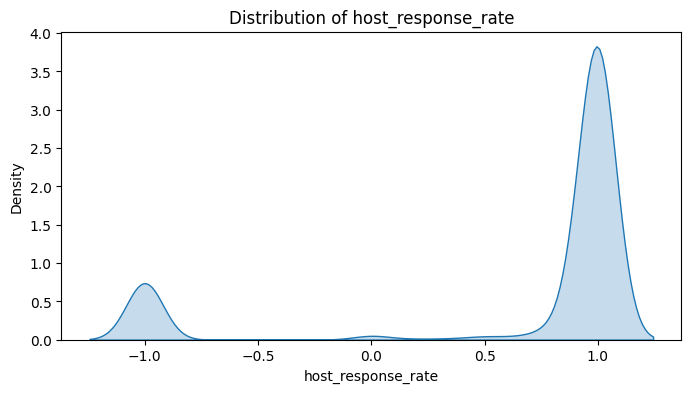

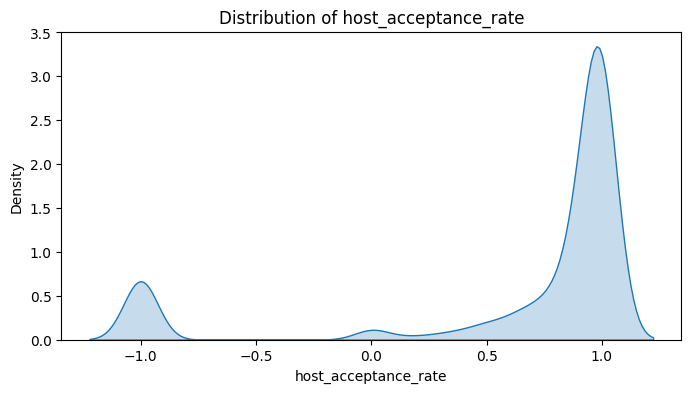

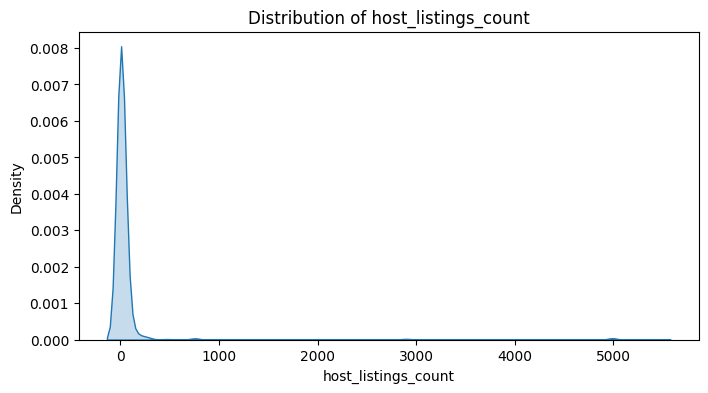

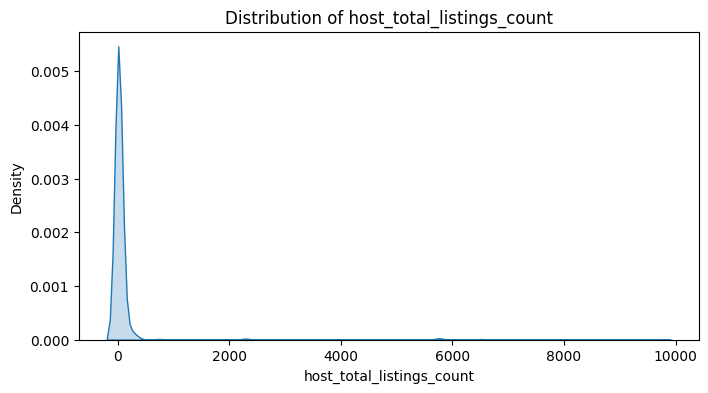

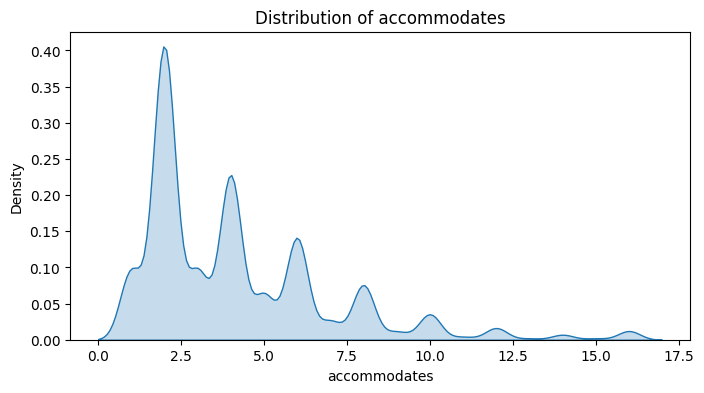

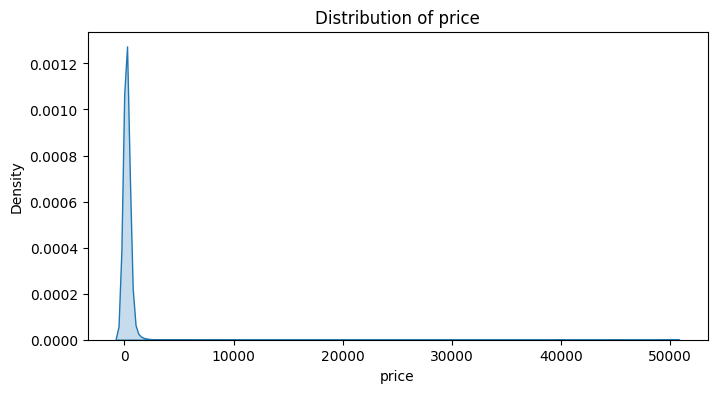

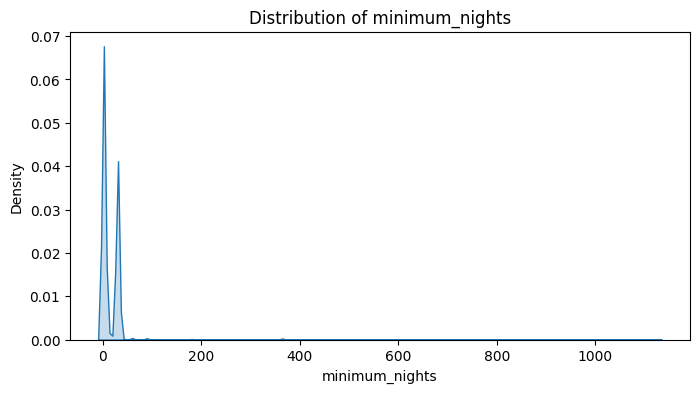

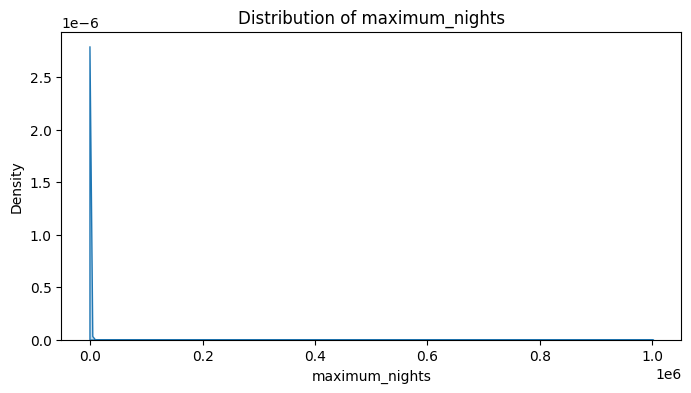

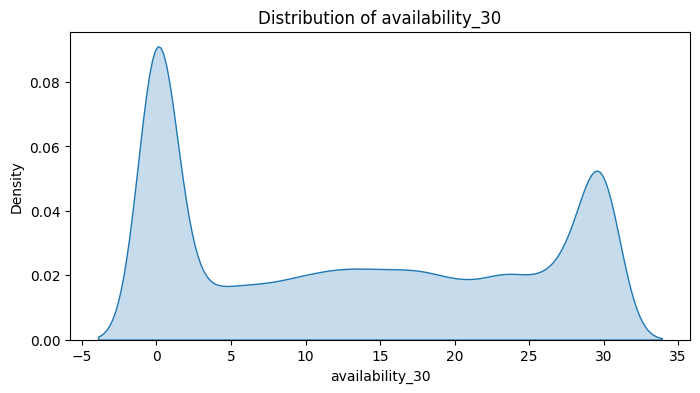

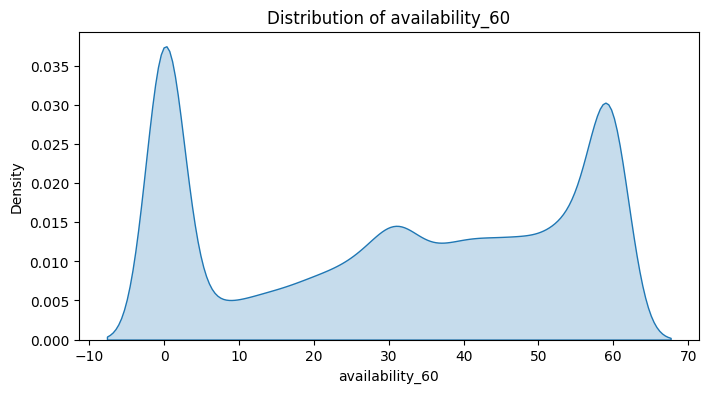

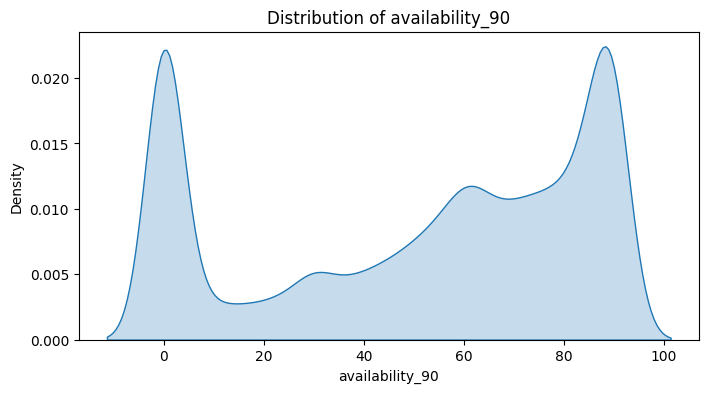

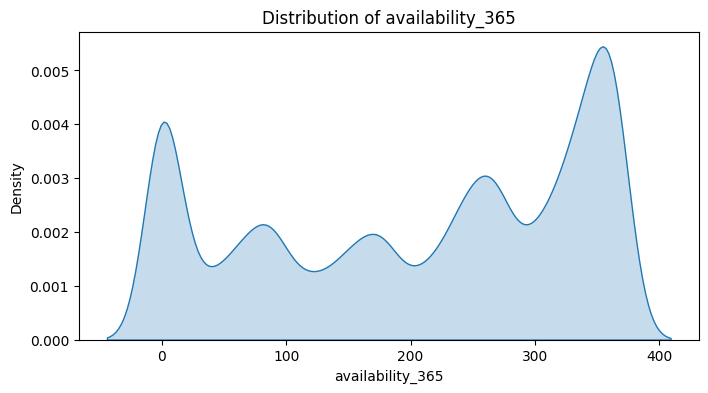

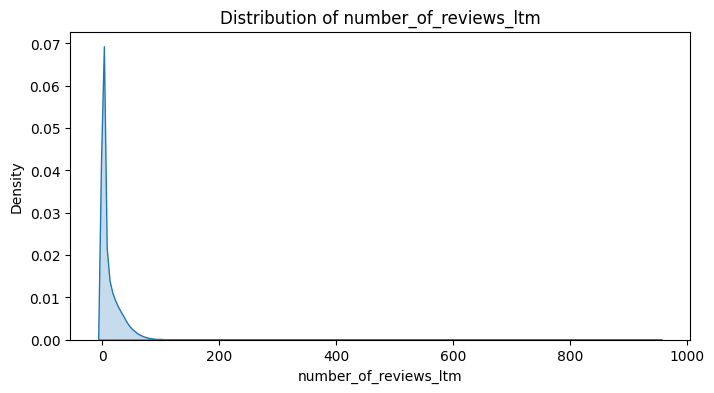

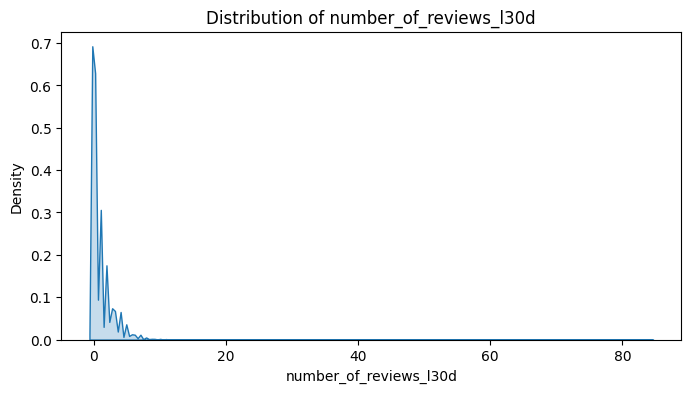

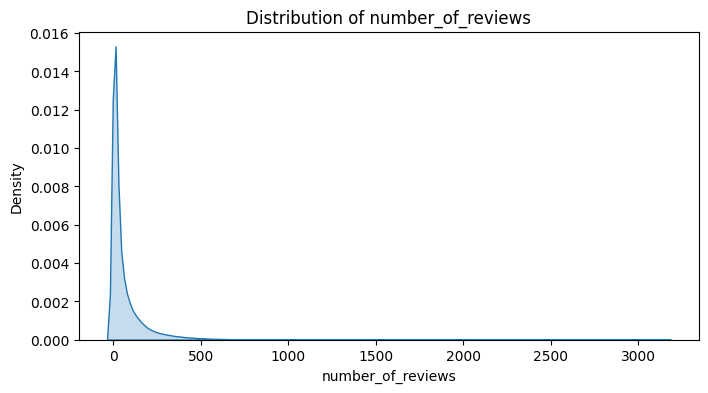

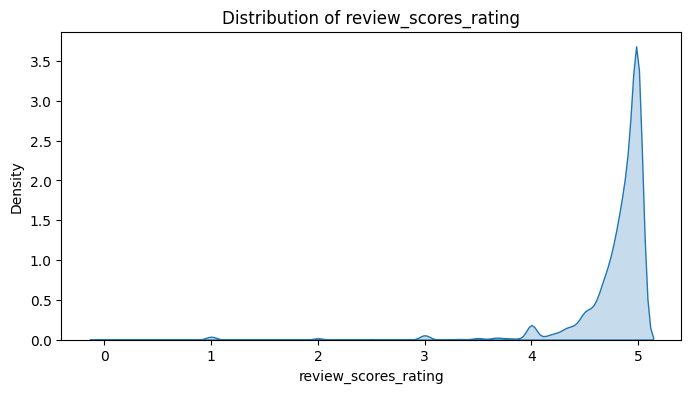

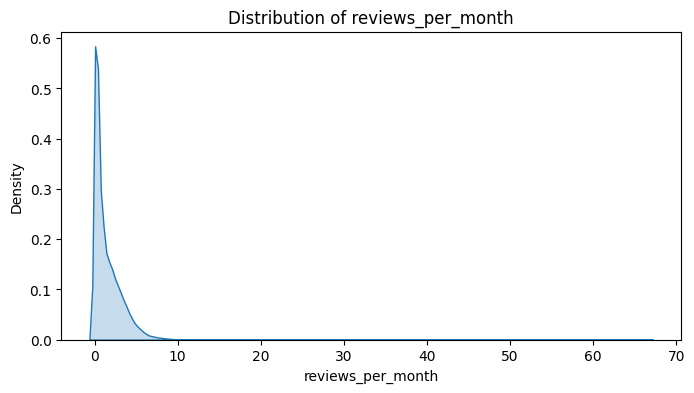

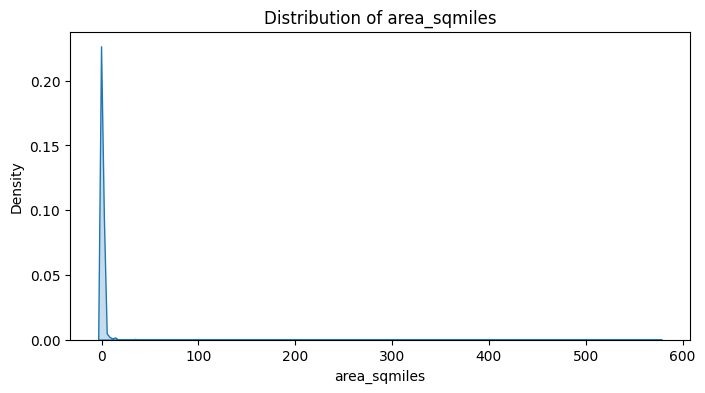

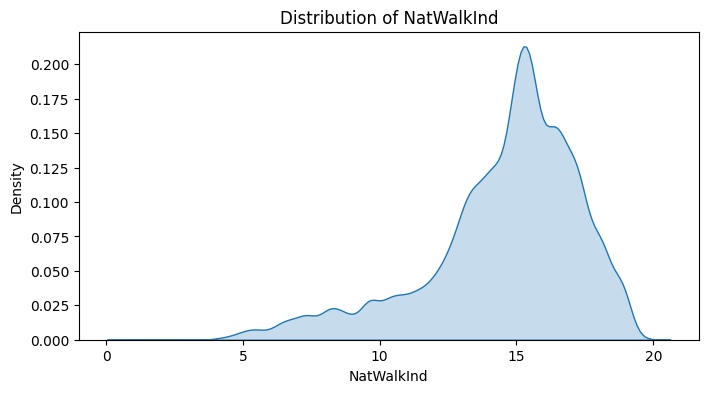

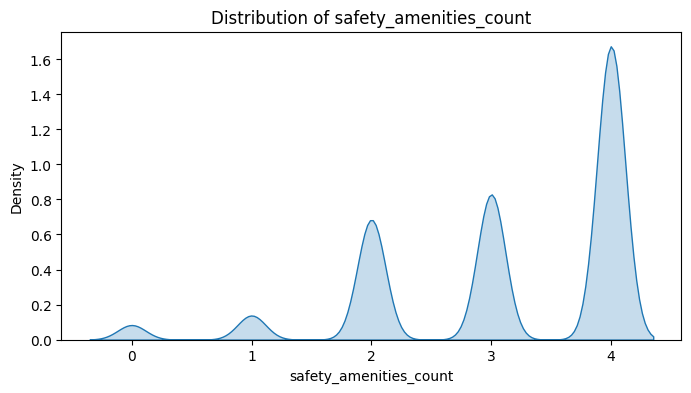

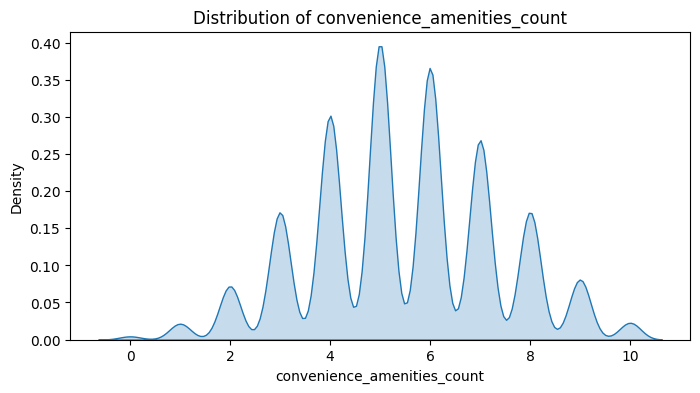

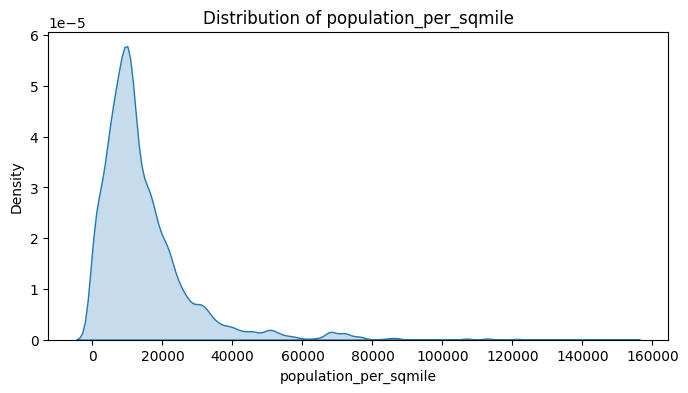

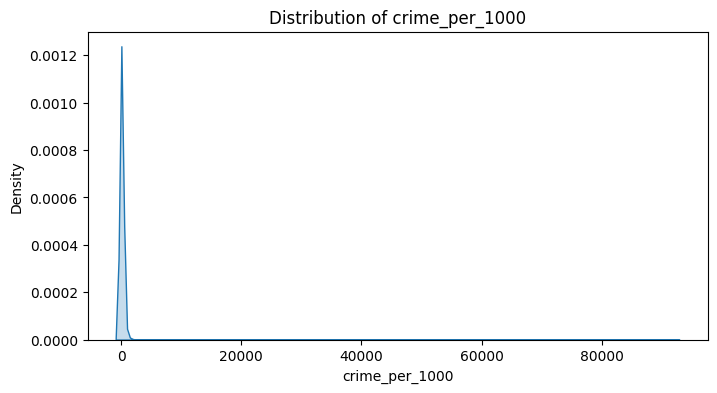

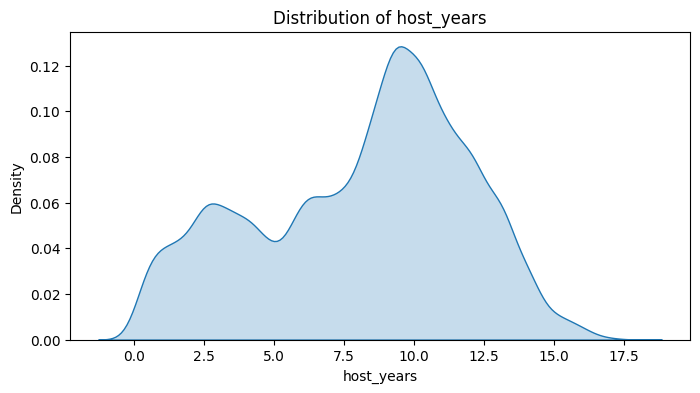

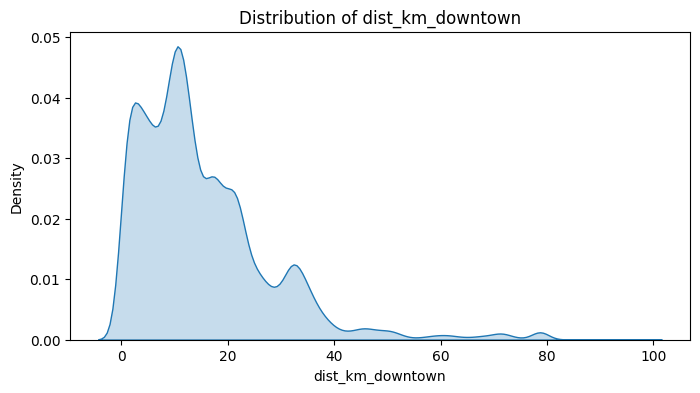

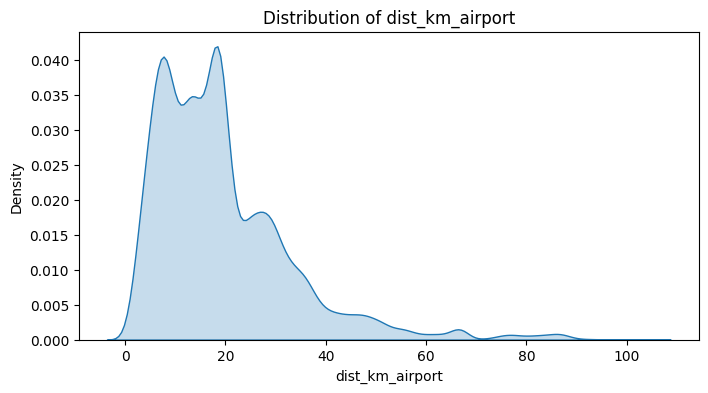

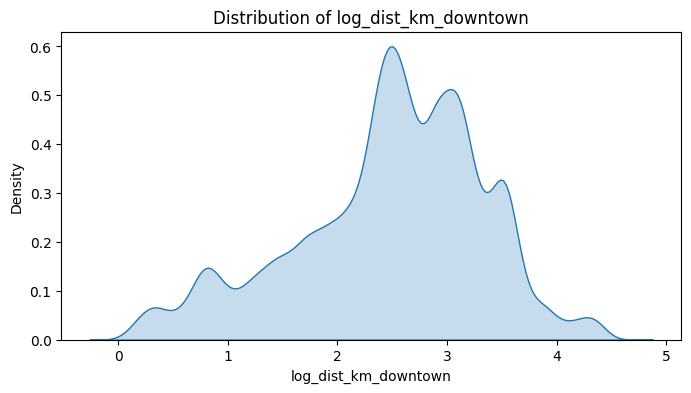

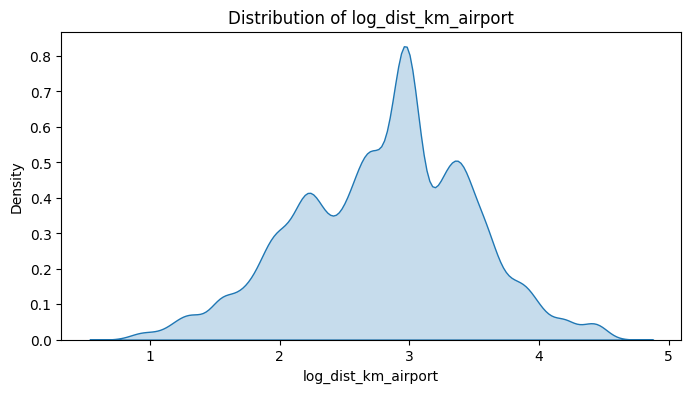

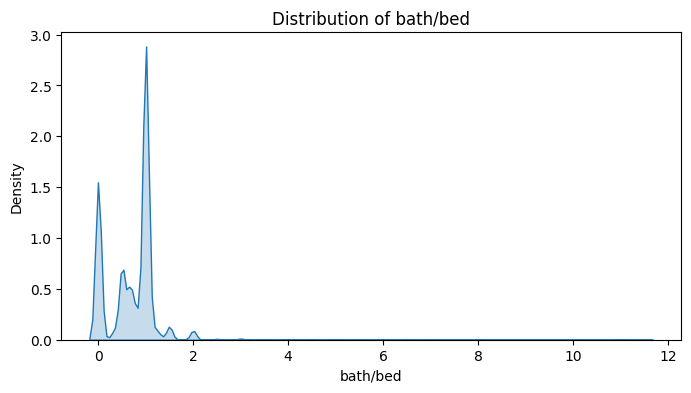

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_numeric_distributions(df, numeric_cols, min_unique=5):
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].dropna().nunique() < min_unique:
            continue
        plt.figure(figsize=(8, 4))
        sns.kdeplot(df[col].dropna(), fill=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()


plot_numeric_distributions(EDA_DF, numeric_cols)

In [55]:
skew_vals = EDA_DF[numeric_cols].skew()
print(skew_vals.sort_values(ascending=False))


maximum_nights                 225.431102
area_sqmiles                    40.649613
crime_per_1000                  33.536068
price                           20.085038
minimum_nights                  15.169042
host_listings_count             11.030443
host_total_listings_count       10.024724
number_of_reviews_ltm            8.273617
number_of_reviews_l30d           7.879778
reviews_per_month                5.634170
number_of_reviews                4.052926
bath/bed                         3.327113
population_per_sqmile            2.905429
dist_km_downtown                 1.811561
dist_km_airport                  1.783170
accommodates                     1.557631
availability_30                  0.166795
convenience_amenities_count      0.016490
availability_60                 -0.193008
log_dist_km_airport             -0.193185
availability_365                -0.319496
host_years                      -0.344847
availability_90                 -0.432447
log_dist_km_downtown            -0

## Notes on distributions:
Distribution of host response rate: left skewed, could think about a droppping outliers

Distribution of host acceptance rate is also left skewed, though I’m not sure if we need a log transformation

Host listing count/total host listing count: right skewed distribution with extreme outliers, could remove outliers or log transform

Accommodates: right skewed slightly

Price: right skewed with extreme variables

Min & max nights: right skewed, maximum nights dimensions/range is different than minimum nights

Availability 30,60,90, 365: bimodal data, might have to categorize these

Number of reviews ltm,l30d,number of reviews: right skewed with extreme outliers

Review scores ratings: left skew,

Reviews per month: right skew

ALAND: right skew with decently sized outliers

Areasqmiles: right skew with extreme outliers

Natwalkindex: slight left skew

Safety amenities count: slight left skew

Convenience amenities count: gaussian

Population sq miles: right skew, with extreme outliers

Distribution of crime per 1000: right skew extreme outliers

Distribution of host years: almost bimodal distribution

Distance log transformations: keep these and discard the original distance features



## Outcome/Target Variable Concerns
Looking at the distributions of the review_ratings and the number of reviews, there is likely going to be an issue with "class imbalance". Not with regards to class imbalance in the classification sense but in the sense that the majority of listings have around a 4-5 star review. We could change the target variable and make it a classifcation problem where we want to see if we can predict a 4-5 star listing vs a listing with less tahn 4 stars. Or we could filter the number of reivews, though we may lose some of the 1-2 star review listings which could exacerbate the imbalance problem.

In [56]:

EDA_corr_matrix=EDA_DF[numeric_cols+categorical_cols].corr()

In [57]:
EDA_corr_matrix

,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,price,minimum_nights,maximum_nights,availability_30,...,host_has_profile_pic,host_identity_verified,instant_bookable,host_response_time_ord,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan,is_unique_stay
host_response_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_rate,NaN,1.000000,0.781755,0.059803,0.063466,0.110446,0.021785,-0.174992,-0.009302,0.189526,...,0.026403,0.090094,0.114213,0.509865,0.087808,0.022320,-0.092305,-0.006263,NaN,0.012042
host_acceptance_rate,NaN,0.781755,1.000000,0.046892,0.051213,0.113630,0.019554,-0.198647,-0.011588,0.124732,...,0.014614,0.090992,0.165607,0.285890,0.097775,0.028620,-0.103185,-0.008663,NaN,0.009119
host_listings_count,NaN,0.059803,0.046892,1.000000,0.924879,-0.015222,0.231236,0.009436,0.013795,0.044866,...,0.017272,0.032443,0.139473,-0.010620,-0.001150,0.256324,-0.044367,-0.007720,NaN,0.011880
host_total_listings_count,NaN,0.063466,0.051213,0.924879,1.000000,0.003866,0.327045,-0.002396,0.015634,0.053371,...,0.018370,0.030475,0.159455,-0.010714,-0.030484,0.412705,-0.043019,-0.008543,NaN,0.011240
accommodates,NaN,0.110446,0.113630,-0.015222,0.003866,1.000000,0.072016,-0.105341,-0.001464,0.082811,...,-0.007535,0.014588,0.116336,0.014660,0.400399,0.002588,-0.398015,-0.056641,NaN,-0.044500
price,NaN,0.021785,0.019554,0.231236,0.327045,0.072016,1.000000,-0.027964,0.006868,0.038430,...,0.006275,-0.024655,0.078912,0.001935,-0.047707,0.508468,-0.043151,-0.007461,NaN,0.031802
minimum_nights,NaN,-0.174992,-0.198647,0.009436,-0.002396,-0.105341,-0.027964,1.000000,0.014933,-0.031110,...,0.015061,-0.010675,-0.093692,-0.007799,0.003842,-0.033735,0.002996,-0.004347,NaN,-0.010163
maximum_nights,NaN,-0.009302,-0.011588,0.013795,0.015634,-0.001464,0.006868,0.014933,1.000000,-0.007249,...,0.003033,-0.000300,0.009621,-0.002041,-0.007295,0.007607,0.006097,-0.000409,NaN,-0.001613
availability_30,NaN,0.189526,0.124732,0.044866,0.053371,0.082811,0.038430,-0.031110,-0.007249,1.000000,...,-0.031806,0.022045,0.069942,0.133633,-0.045744,0.047710,0.031735,0.035713,NaN,0.013174


In [58]:
corrs=np.triu(np.ones(EDA_corr_matrix.shape), k=1).astype(bool)
strong_corrs = EDA_corr_matrix.where(corrs)
strong_corrs = strong_corrs.stack().reset_index()
strong_corrs.columns = ["feature_1", "feature_2", "correlation"]
strong_corrs = strong_corrs[(strong_corrs["correlation"] > 0.60)]
strong_corrs

,feature_1,feature_2,correlation
0,host_response_rate,host_acceptance_rate,0.781755
73,host_listings_count,host_total_listings_count,0.924879
268,availability_30,availability_60,0.923088
269,availability_30,availability_90,0.854490
297,availability_60,availability_90,0.969843
325,availability_90,availability_365,0.638435
378,number_of_reviews_ltm,number_of_reviews_l30d,0.737752
381,number_of_reviews_ltm,reviews_per_month,0.858453
405,number_of_reviews_l30d,reviews_per_month,0.749350
428,number_of_reviews,reviews_per_month,0.609972


In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = EDA_DF[numeric_cols + categorical_cols].drop(columns=['host_response_time_ord','host_response_time','review_scores_rating','room_type_nan','dist_km_downtown',            
'dist_km_airport'])

X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
X.columns


Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'number_of_reviews', 'reviews_per_month',
       'area_sqmiles', 'NatWalkInd', 'safety_amenities_count',
       'convenience_amenities_count', 'population_per_sqmile',
       'crime_per_1000', 'host_years', 'log_dist_km_downtown',
       'log_dist_km_airport', 'bath/bed', 'host_has_profile_pic',
       'host_identity_verified', 'instant_bookable',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'is_unique_stay'],
      dtype='object')

In [60]:
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,host_response_rate,2.729972
1,host_acceptance_rate,2.716374
2,host_listings_count,8.113624
3,host_total_listings_count,9.169859
4,accommodates,1.382211
5,price,1.398538
6,minimum_nights,1.114423
7,maximum_nights,1.001221
8,availability_30,8.407494
9,availability_60,38.951796


## VIF 
Looking at the Vif values, most values above 10 should be considred as correlated

In [61]:
X.var().sort_values()



room_type_Shared room          4.986501e-03
room_type_Hotel room           5.784235e-03
is_unique_stay                 1.432433e-02
host_has_profile_pic           1.575768e-02
host_identity_verified         1.036752e-01
room_type_Private room         1.729672e-01
room_type_Entire home/apt      1.788616e-01
instant_bookable               1.998787e-01
bath/bed                       2.921254e-01
host_acceptance_rate           4.209858e-01
log_dist_km_airport            4.402515e-01
host_response_rate             5.064370e-01
log_dist_km_downtown           7.417831e-01
safety_amenities_count         1.053540e+00
reviews_per_month              3.379095e+00
number_of_reviews_l30d         3.427504e+00
convenience_amenities_count    3.468932e+00
NatWalkInd                     8.006588e+00
accommodates                   8.381713e+00
host_years                     1.407671e+01
area_sqmiles                   1.030964e+02
availability_30                1.309935e+02
number_of_reviews_ltm          3

# Findings and Considerations

## 1. Target Variable considerations:
As mentioned above and in the meeting, there is class imbalance concern with our current target variable number of review_scores_ratings. This is becasue the majority of observations have a rating over 4 stars making it difficult to have our models learn frm observations with fewer than four stars. Furthermore, the number of reviews is also heavliy imbalanced as well per the distribution charts. We could turn this into a binary classication problem where we have listings with under 4 stars as 0 and above 4 stars as 1. We could also still log transform the numberof reviews as it is a right skewed metric and use a square transformation to review scores ratings(we should check the math on this).

## 2. Columns to drop
According to the multicollinearity tests, the columns to drop would be host_listings_count, host_total_listings, some of the availability columns. For linear models, we should try stanrdard scalar or min max scaling should work to scale the data.

In [62]:
csv_filepath = config.PROJECT_ROOT + "/data/preprocessed/EDA_DF.csv"
EDA_DF.to_csv(csv_filepath, index=False)